In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os,glob
import numpy as np
import ffmpeg
from analysis_module import *

def get_fps(path):
    vid_len = ffmpeg.probe(path)["format"]["duration"]
    c = get_frame_count(path)
    return c/float(vid_len)
    
def mean_fps(path):
    fps_arr = []
    for fname in glob.glob(f"{path}/??????/*"):
        fps_arr.append(get_fps(fname))
    return fps_arr

### Screen data

In [2]:
#Pre-Screening
paths = glob.glob("Subjects/s*")
print(len(paths))

#all subjects in trash/Subjects were excluded after fps check except 4
#88 (no data) ad 48 (upload failed:16 but 68 uploads) removed from the remaining four 
#checking 16 and 37 further -> wearing glasses

65


In [3]:
# paths = [path for path in paths if int(path.strip("Subjects/s"))>105]
for path in paths:
    df = pd.read_csv(os.path.join(path,"data.csv"))
    if df.upload_failed.dropna().sum() > 0:
        print("{:13}".format(path), df.upload_failed.dropna().sum(), len(os.listdir(os.path.join(path,str(df.iloc[0].rec_session_id)))))#, df[df.upload_failed==True][["Task_Name","Trial_Nr"]])
        
# What's up with s64? (LabVanced data has upload_failed==True but recordings are present)

Subjects/s86  1 68
Subjects/s114 1 68
Subjects/s64  15 68
Subjects/s43  1 67
Subjects/s17  1 68
Subjects/s32  2 68


In [311]:
## FPS Exclusion criteria

tasks = ['E_calib','SP_calib', '3. FreeView', '2. Smooth Pursuit', '4. Zone Classification','1. Fixation','5. Blink Detect']
screen_out = []

for path in paths: # path = "Subjects/s*"
    df = pd.read_csv(f"{path}/data.csv")
    sub_fps = {k:[] for k in tasks}
    ex_tasks = []
    for task in tasks:
        sub_df = df[df["Task_Name"] == task]
        if task == "3. FreeView":
            sub_df = sub_df[sub_df["Trial_Nr"]!=1] #drop example trial for freeview 
            
        for i,row in sub_df.iterrows():
            try:
                fname = glob.glob(f"{path}/??????/blockNr_{row.Block_Nr}_taskNr_{row.Task_Nr}_trialNr_{row.Trial_Nr}*.webm")[0]
                fps = get_fps(fname)
                sub_fps[task].append(int(fps))
            except Exception as e:
                print(task, row.Trial_Nr, e)
                sub_fps[task].append(0)
            
        valid = sum([i>=25 for i in sub_fps[task]])
        if valid<0.7*sub_df.shape[0]:
            if 'calib' in task:
                screen_out.append(path)
                print(path, task, sub_fps[task])
                print("*"*50)
                break
            else:
                print(path, task, sub_fps[task])
                ex_tasks.append(task)
    else:
        if len(ex_tasks) > 1:
            print(path, ex_tasks)
            screen_out.append(path)
            print("*"*50)

(array([ 1.,  0.,  0.,  2.,  4., 39., 14.,  4.,  2.,  2.]),
 array([29.59028832, 29.63511058, 29.67993283, 29.72475509, 29.76957735,
        29.81439961, 29.85922187, 29.90404413, 29.94886639, 29.99368865,
        30.03851091]),
 <BarContainer object of 10 artists>)

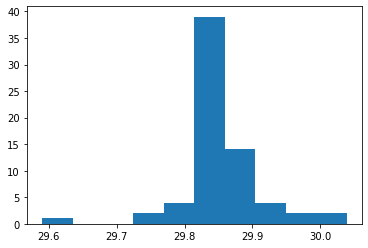

In [325]:
#check fps consistency over a single session (change Subject number accordingly)
l=[]
for path in ["Subjects/s79"]:
    for fname in glob.glob(path+"/??????/*"):
        fps = get_fps(fname)
        l.append(fps)
plt.hist(l)

In [326]:
## FACE DETECTION exclusion criteria
# first perform calib tests using face_detect_calib.py for each model respectively

model = pred_path.ETH

for subb in os.listdir(model.value):
    tasks = {k:0 for k in ["Fixation", "Smooth Pursuit", "Zone Classification", "FreeView"]}
    lpaths = glob.glob(f"{model.value}/{subb}/model_outputs/*/*.csv")
    for trial in lpaths:
        df = pd.read_csv(trial)
        if df.res.isna().sum() > 0.3*df.shape[0]:
            key = ''.join([i for i in trial.split('/')[-1][:-4] if not i.isdigit()])
            tasks[key] += 1
    verify = [tasks["FreeView"]>(0.3*16), tasks["Fixation"]>(0.3*10), tasks["Smooth Pursuit"]>(0.3*10), tasks["Zone Classification"]>(0.3*10)]
    if sum(verify) > 1:
        print(subb, tasks)

In [16]:
# filter_paths = [ p for p in paths if p not in screen_out ]
# len(filter_paths)#.remove("Subjects/s46")

### EDA

In [3]:
#EDA

cdf = pd.DataFrame(columns=['id','task_seq', 'seconds', 't_offset', 't_std', 'loc', 'lang', 'age', 'group', ' fullscreen', ' l1', 'l2', 'l3', 'student', 'gender', 'study', 'vision',"zone","blink","sp", "fix", "browser", "OS", "fps"])
fps_subjects = {}

for path in tqdm(glob.glob("Subjects/*")):
    df = pd.read_csv(f"{path}/data.csv")
    task_seq = eval(df.Block_Name.max().strip("tasks ()"))
    row = df[df["Task_Name"] == "instructions"].iloc[0]
    duration,_ = get_time(row)
    seconds = duration.total_seconds()
    gender = "male" if row.GenderChoice == 'option_1' else 'female'
    psych = "yes" if row.FieldOfStudy == 'option_0' else 'no'
    student = "yes" if row.IsAStudent == 'option_0' else 'no'
    vision = "normal" if row.VisionChoice == 'option_0' else 'corrected'
    
    
#     fname = glob.glob(path+"/*/*BlinkRec.webm")[1]
#     vid_len = ffmpeg.probe(fname)["format"]["duration"]
#     c = get_frame_count(fname)
#     fps = c/float(vid_len)
#     summ = mean_fps(path)
#     fps_min = summ.min()
#     fps_max = summ.max()
#     fps_mean = summ.mean()
    fps_subjects[path.split("/")[1]] = mean_fps(path)
    
    l=[]
    for task in ["4. Zone Classification","5. Blink Detect","2. Smooth Pursuit", "1. Fixation"]:
            sub = df[df["Task_Name"] == task]
            l.append((sub.RecStop -sub.RecStart).sum())
    
    cdf.loc[len(cdf)] = [path.split("/")[1],task_seq, seconds, row.time_delay_offset, row.time_measure_std, row.selected_location, row.selected_language, row.selected_age, row.group_name, row.always_fullscreen, row.Level1, row.Level2, row.Level3, student, gender, psych, vision, l[0], l[1], l[2], l[3], row["browser_spec"], row["system_spec"], np.array(fps_subjects[path.split("/")[1]]).mean()]

100%|███████████████████████████████████████████| 65/65 [45:39<00:00, 42.14s/it]


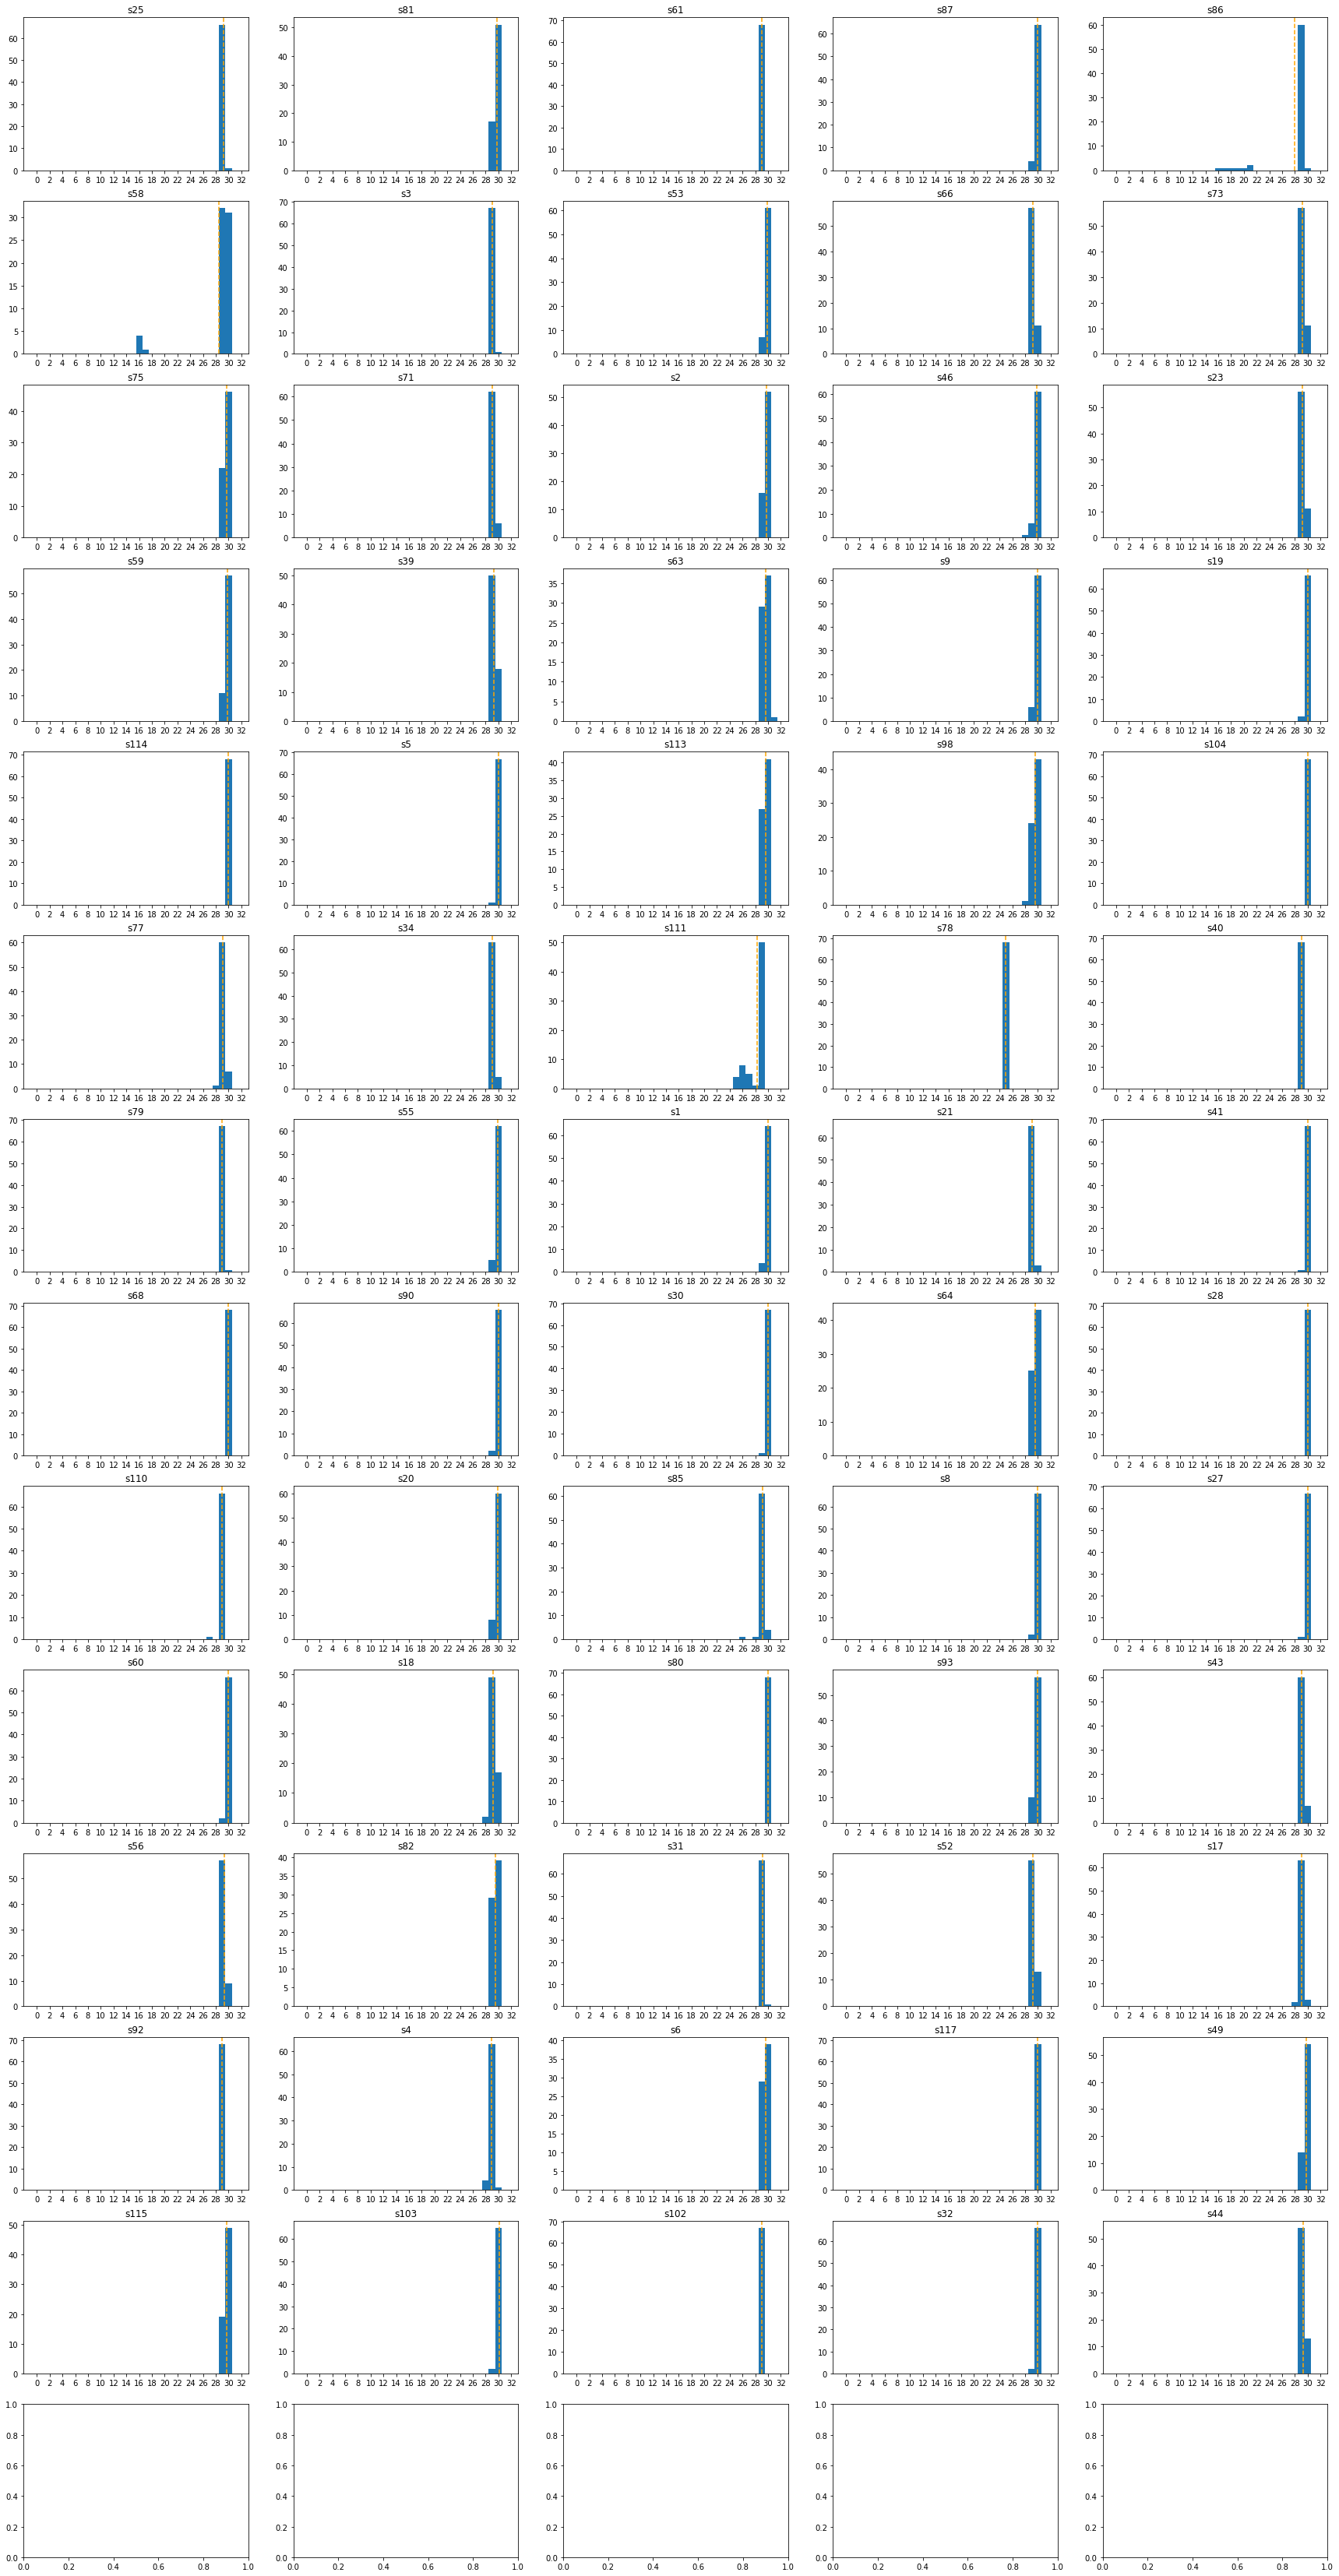

In [4]:
fig,axs = plt.subplots(int(len(fps_subjects)/5)+1,5)
i = 0
fig.set_figheight(60)
fig.set_figwidth(30)
for key,value in fps_subjects.items():
    ax = axs[int(i/5)][i%5]
    arr = np.array(value).astype(int)
    ax.hist(arr, bins = np.arange(0,33)-0.5)
    ax.axvline(arr.mean(),linestyle="--", color="orange")
    ax.set_title(key)
    ax.set_xticks(range(0,33,2))
    ax.set
    i+=1
# plt.savefig('subjects_fps.jpg')

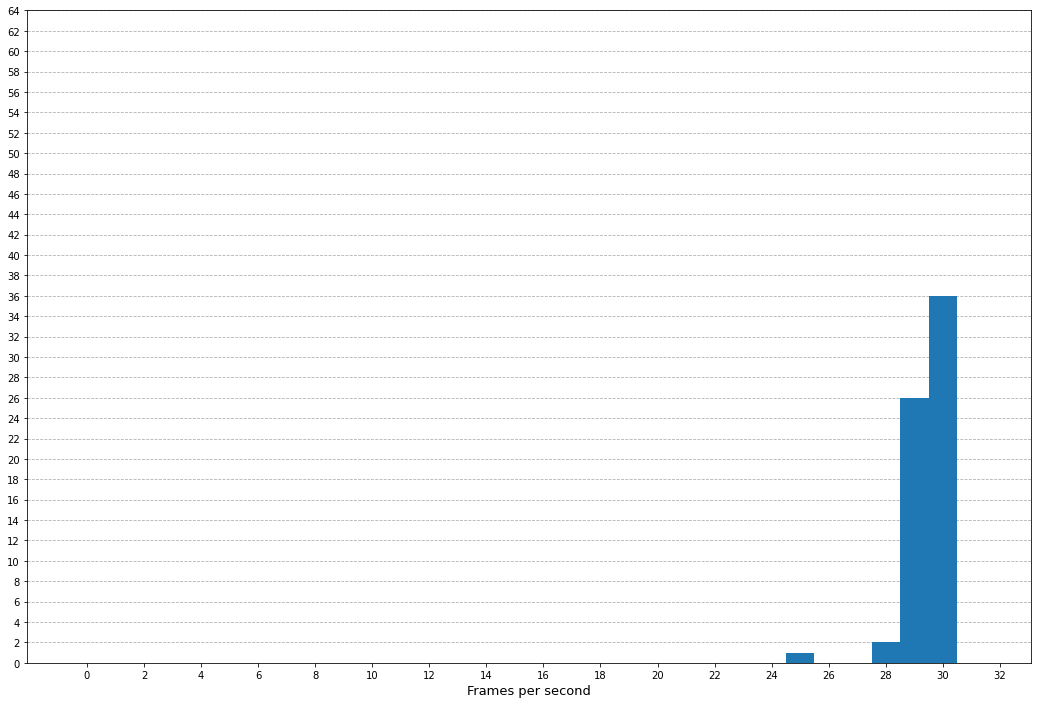

In [5]:
plt.figure(figsize = (18,12))
plt.grid(visible= True, axis="y", linestyle="--", zorder=0)
plt.hist([np.array(x).astype(int).mean() for x in fps_subjects.values()] , np.arange(0,33)-0.5, zorder=3)
plt.xticks(range(0,33,2))
plt.yticks(range(0,65,2))
plt.xlabel("Frames per second", fontsize=13)
plt.savefig("fps_means.jpg")

In [6]:
cdf.corr()

,seconds,zone,blink,sp,fix,fps
seconds,1.000000,-0.062148,-0.061459,0.148300,0.039906,0.026498
zone,-0.062148,1.000000,0.000178,-0.066898,-0.123698,-0.004350
blink,-0.061459,0.000178,1.000000,-0.123960,0.023950,0.099366
sp,0.148300,-0.066898,-0.123960,1.000000,0.435277,0.167424
fix,0.039906,-0.123698,0.023950,0.435277,1.000000,0.122253
fps,0.026498,-0.004350,0.099366,0.167424,0.122253,1.000000


<AxesSubplot:>

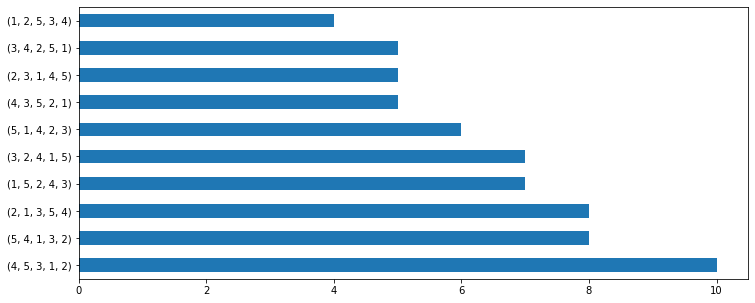

In [346]:
cdf["task_seq"].value_counts().plot.barh(figsize=(12,5))

<AxesSubplot:>

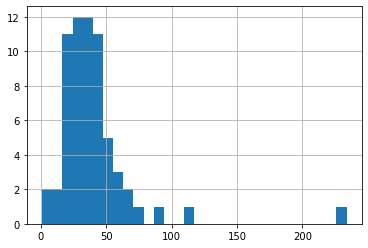

In [ ]:
## not all subjects since LabVanced dropped the variable impromptly 
pd.Series([float(i.strip(" ms")) for i in cdf.t_offset if i != "not measured"]).hist(bins = 30)

<AxesSubplot:>

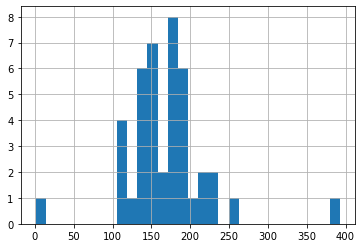

In [379]:
## not all subjects since LabVanced dropped the variable impromptly 
cdf.t_std.dropna().apply(lambda x: float(x.strip(" ms"))).hist(bins = 30)

In [380]:
cdf['loc'].value_counts()

DE    62
AT     1
NL     1
FR     1
Name: loc, dtype: int64

In [381]:
cdf['lang'].value_counts()

de    51
en     5
zh     3
pt     2
ko     2
ru     1
ro     1
Name: lang, dtype: int64

In [382]:
cdf['browser'].value_counts()

Chrome     25
Safari     10
Firefox     6
Opera       1
Name: browser, dtype: int64

Windows-PC    23
Mac/OS-X      19
Name: OS, dtype: int64

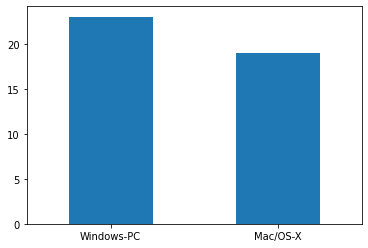

In [383]:
cdf["OS"].value_counts().plot.bar(rot=0); cdf["OS"].value_counts()

count    65.000000
mean     26.046154
std       3.550664
min      20.000000
25%      24.000000
50%      25.000000
75%      28.000000
max      35.000000
Name: age, dtype: float64


<AxesSubplot:>

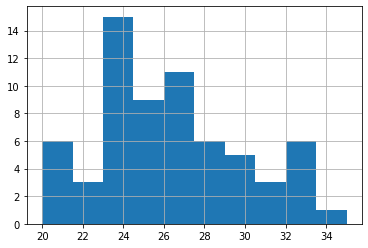

In [384]:
print(cdf.age.astype(float).describe())
cdf.age.hist()

In [385]:
#temp : these sujects can be used for presentations snip
temp = cdf[cdf[["l2","l3"]].sum(axis=1) == 2]
temp = temp[["l2","l3","id"]]

In [389]:
#save images for collage
os.mkdir("temp")
for s in temp.id:
    print(s)
    file = np.random.choice(glob.glob(f"Subjects/{s}/*/*.webm"))
    cap = cv2.VideoCapture(file)
    randin = int(np.random.randn()*50)
    i=0
    while True:
        i+=1
        ret,f = cap.read()
        if not ret:
            print("ERROR",file,s, i)
            break
        elif i>randin:
            break
    if ret:
        x = cv2.imwrite(f"temp/{s}.jpg", f)
        print(f"saved temp/{file[:-5]}.jpg", x)
        

s61
saved temp/Subjects/s61/323348/blockNr_13_taskNr_9_trialNr_2_recordZone.jpg True
s3
saved temp/Subjects/s3/322260/blockNr_4_taskNr_3_trialNr_1_video_calib.jpg True
s53
saved temp/Subjects/s53/339942/blockNr_6_taskNr_15_trialNr_7_freeViewRec.jpg True
s66
saved temp/Subjects/s66/325452/blockNr_4_taskNr_3_trialNr_1_calib_sp_record.jpg True
s46
saved temp/Subjects/s46/327539/blockNr_13_taskNr_6_trialNr_1_recordZone.jpg True
s114
saved temp/Subjects/s114/426879/blockNr_13_taskNr_15_trialNr_1_pursuit_rec.jpg True
s34
saved temp/Subjects/s34/321411/blockNr_6_taskNr_11_trialNr_1_pursuit_rec.jpg True
s78
saved temp/Subjects/s78/398815/blockNr_4_taskNr_2_trialNr_1_video_calib.jpg True
s79
saved temp/Subjects/s79/398973/blockNr_6_taskNr_9_trialNr_3_recordZone.jpg True
s90
saved temp/Subjects/s90/412774/blockNr_13_taskNr_9_trialNr_7_freeViewRec.jpg True
s60
saved temp/Subjects/s60/339116/blockNr_13_taskNr_12_trialNr_2_BlinkRec.jpg True
s4
saved temp/Subjects/s4/330147/blockNr_6_taskNr_12_trial

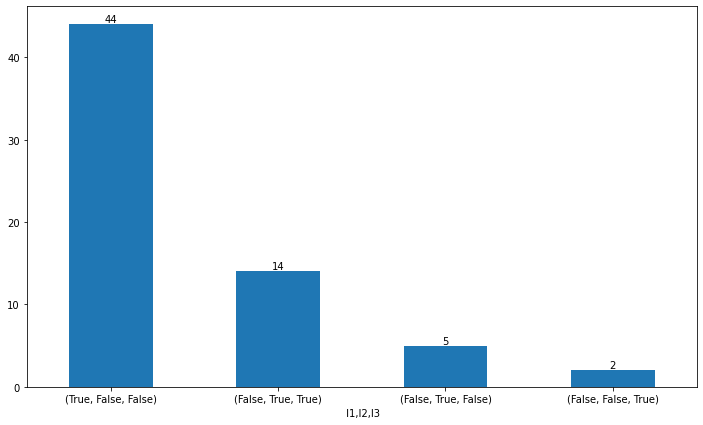

In [390]:
# Consent Level
ax = cdf[[" l1","l2","l3"]].value_counts().plot.bar(rot=0, figsize=(12,7))
for container in ax.containers:
    ax.bar_label(container)

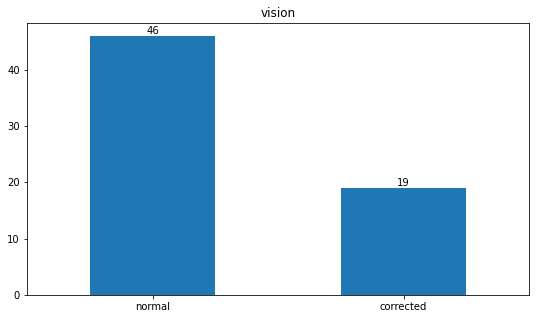

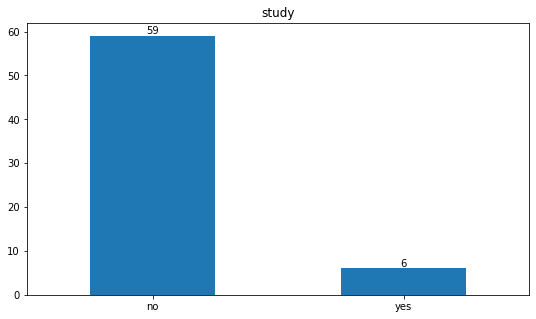

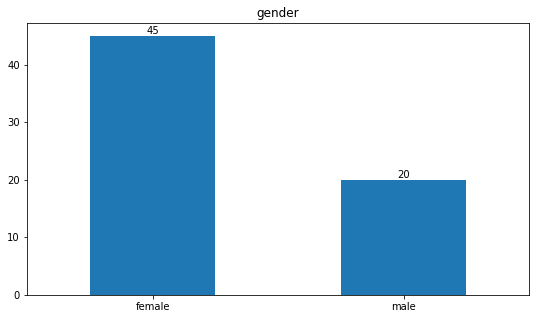

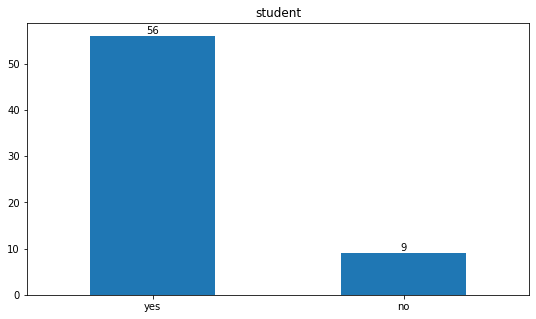

In [391]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['vision','study','gender','student']:
    ax = cdf[i].value_counts().plot.bar(rot=0, figsize = (9,5))
    ax.bar_label(ax.containers[0])
    plt.title(i)
    plt.show()

## Time taken for tasks

count                           65
mean     0 days 01:04:24.738461538
std      0 days 02:10:14.028111105
min                0 days 00:34:30
25%                0 days 00:41:45
50%                0 days 00:47:34
75%                0 days 00:52:40
max                0 days 18:15:36
Name: seconds_td, dtype: object

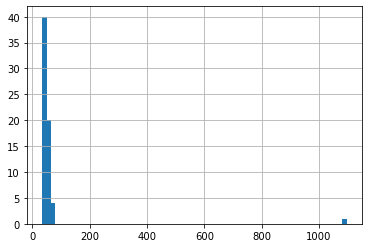

In [415]:
cdf["seconds_td"] = pd.to_timedelta(cdf.seconds,'s')
# hours = seconds // 3600
# minutes = (seconds % 3600) // 60
# seconds = seconds % 60
# print("Avg time: ", hours,"hours",minutes,"minutes",seconds,"seconds")
(cdf.seconds/60).hist(bins=70)
cdf["seconds_td"].describe()

In [416]:
cdf.sort_values(by="seconds", ascending= False)[["id","seconds_td"]].head()
#Whats up with s75?

,id,seconds_td
10,s75,0 days 18:15:36
49,s43,0 days 01:17:01
44,s27,0 days 01:13:24
42,s85,0 days 01:10:47
3,s87,0 days 01:09:19


count                           65
mean     0 days 00:04:47.424292307
std      0 days 00:00:00.363394917
min         0 days 00:04:47.174000
25%         0 days 00:04:47.249000
50%         0 days 00:04:47.297000
75%         0 days 00:04:47.374000
max         0 days 00:04:48.688000
Name: zone, dtype: object

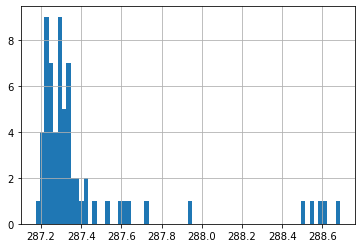

In [427]:
#ZONE
seconds = pd.to_timedelta(cdf.zone,'ms')
(cdf.zone/1000).hist(bins=70)
seconds.describe()

count                           65
mean     0 days 00:05:20.277415384
std      0 days 00:00:35.268499203
min         0 days 00:04:26.167000
25%         0 days 00:04:54.201000
50%         0 days 00:05:11.231000
75%         0 days 00:05:32.461000
max         0 days 00:07:05.209000
Name: sp, dtype: object

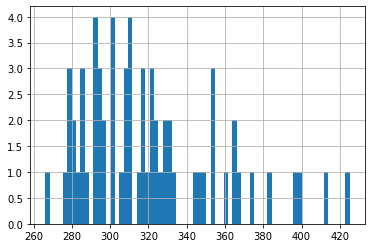

In [428]:
#Smooth Pursuit
seconds = pd.to_timedelta(cdf.sp,'ms')
(cdf.sp/1000).hist(bins=70)
seconds.describe()

count                           65
mean     0 days 00:07:52.777815384
std      0 days 00:01:04.824213803
min         0 days 00:06:34.001000
25%         0 days 00:07:11.368000
50%         0 days 00:07:33.746000
75%         0 days 00:08:13.816000
max         0 days 00:12:21.083000
Name: fix, dtype: object

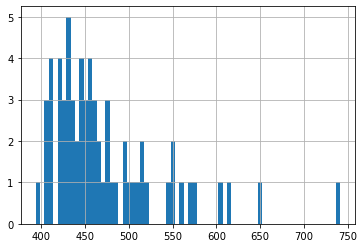

In [429]:
#Fixation
seconds = pd.to_timedelta(cdf.fix,'ms')
(cdf.fix/1000).hist(bins=70)
seconds.describe()

count                           65
mean     0 days 00:02:16.308769230
std      0 days 00:00:10.354844155
min         0 days 00:02:07.758000
25%         0 days 00:02:09.725000
50%         0 days 00:02:11.208000
75%         0 days 00:02:21.655000
max         0 days 00:02:42.182000
Name: blink, dtype: object

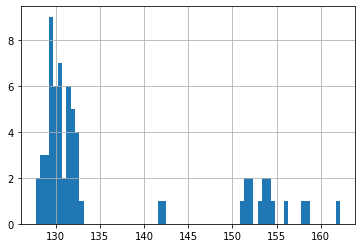

In [431]:
#BLINK
seconds = pd.to_timedelta(cdf.blink,'ms')
(cdf.blink/1000).hist(bins=70)
seconds.describe()

In [433]:
l={}
for path in paths:
    df = pd.read_csv(os.path.join(path,"data.csv"))
    df = df[df.Task_Name == "E_calib"]
    l[path.split('/')[1]] = df.miss_count.sum()

(array([38., 18.,  0.,  4.,  0.,  4.,  0.,  0.,  0.,  1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

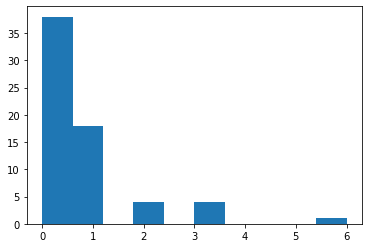

In [434]:
#no subject has too many incorrect responses in E_calib task!
plt.hist(l.values())

<AxesSubplot:>

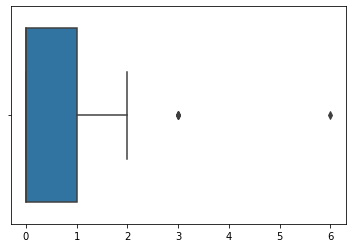

In [439]:
sns.boxplot(x=list(l.values()))